<a href="https://colab.research.google.com/github/luisedchaf/tesis/blob/main/Control_MPC_con_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Código de control MPC para fertirriego 
*Luis Eduardo Chamorro*



10/03/2022

## Libraries

In [5]:
!pip install qpsolvers
!pip install psycopg2

In [6]:
# Import libraries
import statistics
import math                       # Para funciones matemáticas
import pandas as pd               # Para manejo y análisis de estructura de datos
import numpy as np                # Cálculo numérico y el análisis de datos
import matplotlib.pyplot as plt   # Para gráficas
from cvxopt import matrix, solvers
from qpsolvers import solve_qp
import scipy.sparse as spa
import osqp
from scipy import linalg as la
import psycopg2 
from datetime import datetime, timedelta
#pip install quadprog
#import pdb

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Query Database Functions

In [7]:
def run_query(query=''):
  DB_HOST = '192.68.185.26' 
  DB_USER = 'inv_luis_eduardo' 
  DB_PASS = '12345678*aA' 
  DB_NAME = 'cafiot' 
  conexion = psycopg2.connect(host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASS)
  df = pd.read_sql(query,conexion)  # data frame
  conexion.close()
  return df

## Sensor query

In [8]:
# Code to query the sensors to the database.
# Host in "DATA".
def consulta(year,month,day,hour1,hour2,minute,sensor):
  consulta = """
  SELECT valor1, fecha, topic, s.nombre, key, observacion, color, valor_max, valor_min, tm.nombre, um.nombre
  FROM mediciones AS m 
  INNER JOIN sensores AS s
  ON s.id = m.id_sensor 
  INNER JOIN tipos_mediciones AS tm 
  ON tm.id = s.id_tipo_medicion
  INNER JOIN unidades_medidas AS um 
  ON tm.id_und_medida = um.id
  WHERE key = '{sensor}' -- Temperatura --TMAX TMIN TMED
  AND fecha BETWEEN '{year}/{month}/{day} {hour2}:{minute}:00' AND '{year}/{month}/{day} {hour1}:{minute}:00'
  """.format(year=year,month=month,day=day,hour1=hour1,minute=minute,hour2=hour2,sensor=sensor)
  DATA = run_query(consulta)
  return DATA

In [9]:
# consult one hour before
now=datetime.now()
now = now-timedelta(hours=5)
now2 = now-timedelta(hours=1)
year = now.year
month = now.month
day = now.day
hour1 = now.hour
hour2 = now2.hour
minute = now.minute

In [10]:
print(hour1)
print(hour2+0.5)

15
14.5


In [11]:
# Extract from DATA the temperature values
sensor = 'c9478c82-081b-4cbc-b296-107b971d3a18'
temp = consulta(year=year,month=month,day=day,hour1=hour1,minute=minute,hour2=hour2,sensor=sensor)
temp_max = temp.valor1.max()
temp_min = temp.valor1.min()
temp_med = (temp_max+temp_min)/2
#print('Temperatura min:{}\nTemperatura Maxima:{}\nTemperatura Media:{}'.format(temp_min,temp_max,temp_med))

In [12]:
# Extract from DATA the solar radiation values
sensor_rad = '26547499-9f22-465e-abbb-fa1a4769aa04' #radiacion
Radiation1 = consulta(year=year,month=month,day=day,hour1=hour1,minute=minute,hour2=hour2,sensor=sensor_rad) #consult the radiation on the previous hour
Radiation = statistics.mean(Radiation1.valor1) # average radiation
print('Radiacion:{}'.format(Radiation))

Radiacion:297.8888513513514


In [13]:
# Extract from DATA the wind speed values
sensor_wind = '63005737-45c1-4f2f-8a46-9eadf77d2841'
wind_sp = consulta(year=year,month=month,day=day,hour1=hour1,minute=minute,hour2=hour2,sensor=sensor_wind)
wind_avg = wind_sp.valor1.mean()
print('Wind:{}'.format(wind_avg))

Wind:1.3006756756756757


In [14]:
# Extract from DATA the ambient humidity values
sensor_hum = '93afd49e-9e22-4388-ba1c-126708d88820'
humidity = consulta(year=year,month=month,day=day,hour1=hour1,minute=minute,hour2=hour2,sensor=sensor_hum)
humidity_avg = humidity.valor1.mean()
print('Humidity:{}'.format(humidity_avg))


Humidity:91.060472972973


In [15]:
# Julian day
day_of_year = datetime.now().timetuple().tm_yday
print(day_of_year)

83


## ETo_Penman

### climatological data hosted on drive

In [ ]:
z     = 2200           # Elevación sobre el nivel del mar
J     = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Juliano_mayo.xlsx', sheet_name='Hoja1') #Día Juliano
lat   = 1+(21/60)     # Latitud de la estación La Mina
long  = -77.29086111     # Longitud de la estación La Mina
t1         = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/hora_estandar.xlsx', sheet_name='Hoja1') 
TMAX       = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Temperatura_Max_diaria_hora.xlsx', sheet_name='Hoja1')
TMIN       = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Temperatura_Min_diaria_hora.xlsx', sheet_name='Hoja1')
TMED       = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Temperatura_Med_diaria_hora.xlsx', sheet_name='Hoja1')
RAD_SOL    = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Radiacion_solar_diaria_hora.xlsx', sheet_name='Hoja1')
VEL_VIENTO = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Vel_viento_diaria_hora.xlsx', sheet_name='Hoja1')
HR_MED     = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/4. Tesis/Datos_Estaciones/Mina_Humedad_Relativa_diaria_hora.xlsx', sheet_name='Hoja1')
d = len(TMED.index)

**Climatological data hosted on Cafiot**

In [16]:
z          = 2200             # Elevation above sea level
J          = day_of_year      # Julian day
lat        = 1+(21/60)        # Latitude
long       = -77.29086111     # longitude
t1         = hour2+0.5        # standard hour 
TMAX       = temp_max
TMIN       = temp_min
TMED       = temp_med
RAD_SOL    = Radiation
VEL_VIENTO = wind_avg
HR_MED     = humidity_avg

In [ ]:
print(t1)

16.5


### Parameters ETo

In [17]:
# Pendiente de la curva de presión de saturación de vapor (Δ): 
# Pagina 57 
# EC.13

## With a for cycle

#Delta = []              # Variable para alojar calculo

#for n in range(d):
    #Delta.append(4098*(0.6108*np.exp(17.27*TMED.TMED[n]/(TMED.TMED[n]+237.3)))/(TMED.TMED[n]+237.3)**2)  #Pág. 57                        

#Delta = np.array(Delta)

## without a for cycle
Delta = (4098*(0.6108*np.exp(17.27*TMED/(TMED+237.3)))/(TMED+237.3)**2)            

print(Delta)
#plt.plot(Deltahr)

0.19413722151601154


In [18]:
# Presión Atmosférica (P) [kPa]:
# La presión atmosférica, P, es la presión ejercida por el peso de la atmósfera terrestre. 
# Pag 52 de documento

P = 101.3*((293-0.0065*z)/293)**5.26

print(P)

77.85853321308541


In [19]:
# Constante Psicrométrica (ϒ) [kPa/°C]:
Cp = 1.01*(10**-3)              # Calor específico a presión constante 
E  = 0.622                      # Cociente del peso molecular de vapor de agua /aire seco
lambd_a = 2.45                  # Calor latente de vaporización

Upsilon = (Cp*P)/(E*lambd_a)    # Ecuación (8) pág. 52

print(Upsilon)

0.05160254514418024


In [20]:
# Presión media de vapor de la saturación  (e_s)    REVISAR!!!!

# Presión de satudación de vapor a Tmax (e_o)

#print(min(TMAX.TMAX))

#e_0Tmax = []
#for n in range(d):
  e_0Tmax.append(0.6108*math.exp((17.27*TMAX.TMAX[n])))   

#e_0Tmax = np.array(e_0Tmax)

# Presión de satudación de vapor a Tmin(e_o)

#e_0Tmin = []
#for n in range(d):
    #e_0Tmin.append(0.6108*math.exp((17.27*TMIN.TMIN[n])))

#e_0Tmin = np.array(e_0Tmin)

# Presión media de vapor de la saturación (e_s)
# e_s = []
#for n in range(1,d+1):
#     e_0Tmin.append(e_0Tmax[n-1]+e_0Tmin[n-1])/2

#print(e_0Tmax)
#print('*\n \n')
#print(e_0Tmin)
#plt.plot(e_0Tmax)
#plt.plot(e_0Tmin)

IndentationError: ignored

In [21]:
e_0Tmax=(0.6108*math.exp((17.27*TMAX)/(TMAX+237.3)))
e_0Tmin=(0.6108*math.exp((17.27*TMIN)/(TMIN+237.3)))
e_s = (e_0Tmax-e_0Tmin)/2

In [ ]:
#print(e_0Tmax)
#print(e_0Tmin)
#print(e_s)

In [22]:
# Parámetro A
#P_Ahr = []              # Variable para alojar calculo

#for n in range(d):
#    P_Ahr.append(1+0.34*VEL_VIENTO.Viento_1[n])  

#P_Ahr = np.array(P_Ahr)

#print(P_Ahr)
#plt.plot(P_Ahr)

P_Ahr = 1+0.34*VEL_VIENTO
#print(P_Ahr)

In [23]:
# Parámetro B
#P_Bhr = []              # Variable para alojar calculo

#for n in range(d):
#    P_Bhr.append(Delta[n]/(Delta[n] + Upsilon*(P_Ahr[n]))) 

#P_Bhr = np.array(P_Bhr) 

P_Bhr = Delta/(Delta+Upsilon*P_Ahr)
print(P_Bhr)
#plt.plot(P_Bhr)

0.7228822623212836


In [24]:
# Parámetro C

#P_Chr = []                        # Variable para alojar calculo

#for n in range(d):
#    P_Chr.append(Upsilon/Delta[n]+Upsilon*P_Ahr[n])

#P_Chr = np.array(P_Chr) 

P_Chr = Upsilon/(Delta+Upsilon*P_Ahr)
print(P_Chr)
#plt.plot(P_Chr)

0.1921453510257673


In [25]:
# Parámetro D
#P_Dhr = []                       # Variable para alojar calculo

#for n in range(d):
#    P_Dhr.append(37/(TMED.TMED[n]+273)*VEL_VIENTO.Viento_1[n])

#P_Dhr = np.array(P_Dhr)
P_Dhr = (900/(TMED+273))*VEL_VIENTO
print(P_Dhr)


3.920978422736922


In [ ]:
# Parámetro E

#e0_Tmaxhr = []                        # Variable para alojar calculo
    
#for n in range(d):
#    e0_Tmaxhr.append(0.6108*np.exp((17.27*TMAX.TMAX[n])/(TMAX.TMAX[n]+273.3)))

#e0_Tmaxhr = np.array(e0_Tmaxhr)

#plt.plot(e0_Tmaxhr)

In [ ]:
 # Presión de saturación de vapor a la temperatura mínima del aire (e0 Tmax)[kPa]

 #e0_Tminhr = []

 #for n in range(d):
 #   e0_Tminhr.append(0.6108*np.exp((17.27*TMIN.TMIN[n])/(TMIN.TMIN[n]+273.3)))

#e0_Tminhr = np.array(e0_Tminhr) 

#plt.plot(e0_Tminhr)

In [28]:
# Presión media de vapor de saturación (es)[kPa]
#eshr = []                        # Variable para alojar calculo
    
#for n in range(d):
#    eshr.append((e0_Tmaxhr[n]+e0_Tminhr[n])/2)

#eshr = np.array(eshr) 
e0_Tmaxhr = 0.618*np.exp((17.27*TMAX)/(TMAX+237.3)) 
e0_Tminhr = 0.618*np.exp((17.27*TMIN)/(TMIN+237.3)) 
eshr = (e0_Tmaxhr+e0_Tminhr)/2


In [29]:
# Presión de saturación de vapor a la temperatura media del aire (eo Tmed) [kPa]
#e0_Tmedhr = [];                        # Variable para alojar calculo
    
#for n in range(d):
#    e0_Tmedhr.append(0.6108*math.exp((17.27*TMED.TMED[n])/(TMED.TMED[n]+273.3))) 

#e0_Tmedhr = np.array(e0_Tmedhr) 
e0_Tmedhr = 0.6108*np.exp((17.27*TMED)/(TMED+237.3))


In [30]:
# Presión real de vapor (ea) [kPa]
#eahr = []                        # Variable para alojar calculo
    
#for n in range(d):
#    eahr.append((HR_MED.HR[n]/100)*e0_Tmedhr[n]) 

#eahr = np.array(eahr) 
eahr = (HR_MED/100)*e0_Tmedhr
#print(HR_MED_hr.head())

In [31]:
# Parámetro E horario
#P_Ehr = []

#for n in range(d):
#        P_Ehr.append(eshr[n]-eahr[n])

#P_Ehr = np.array(P_Ehr)
P_Ehr = (eshr-eahr) 
#plt.plot(eshr)

In [ ]:
# Parámetro F

# Calculo de Radiación extraterrestre por hora (Ra)

# Constante solar
Gsc = 0.082

# distancia relativa inversa Tierra-Sol, dr
dr = []

for n in range(d):
  dr.append(1+0.033*math.cos((2*math.pi/365)*J.Juliano[n]))

dr = np.array(dr)
#print(dr)

# declinación solar, ds 
ds = []
for n in range(d):
    ds.append(0.409*math.sin((2*math.pi/365)*J.Juliano[n]-1.39))

ds = np.array(ds)
#print(ds) 

# Latitud en Radianes

lat_rad = (math.pi/180)*lat
#print(lat_rad)

# Corrección Estacional

b = []
for n in range(d):
    b.append(2*math.pi*((J.Juliano[n]-81)/364))

b = np.array(b)

Sc = []

for n in range(d):
    Sc.append(0.1645*math.sin(2*b[n])-0.1255*math.cos(b[n])-0.025*math.sin(b[n]))

b = np.array(b)

# Angulo solar

w = []

for n in range(d):
  w.append(math.pi/12*(t1.Hora_std[n]+0.06667*((75-77)+Sc[n])-12))

w = np.array(w)

# Angulos de radiación solar al incio y al final

w1 =[]

for n in range(d):
  w1.append(w[n]-(math.pi/24))

w1 = np.array(w1)

w2 =[]

for n in range(d):
  w2.append(w[n]+(math.pi/24))

w2 = np.array(w2)

# Ra

Ra = []

for n in range(d):
  #Ra.append((12*60/math.pi)*Gsc*dr*((w2[n]-w1[n])*math.sin(lat_rad)*math.sin(ds[n])+math.cos(lat_rad)*math.cos(ds[n])*(math.sin(w2[n])-math.sin(w1[n]))))
  Ra.append(((12*60/math.pi)*Gsc*dr[n]*((w2[n]-w1[n])*math.sin(lat_rad)*math.sin(ds[n])+math.cos(lat_rad)*math.cos(ds[n])*(math.sin(w2[n])-math.sin(w1[n])))))
Ra = np.array(Ra)

#print(Ra)

In [ ]:
# Radiación solar en un día despejado (Rso)
Rso = []

for n in range(d):
  Rso.append((0.75 + 2*10**-5*z)*Ra[n]) 

Rso = np.array(Rso)
#print(Rso)


In [ ]:
# Radiación neta solar o de onda corta (Rns): Ecuación 38 Pag.72

Rns = []                        # Variable para alojar calculo
    
for n in range(d):
    Rns.append(0.77*RAD_SOL.Rad_Ajus[n])

Rns = np.array(Rns)
#print(Rns)

In [ ]:
# Radiación neta de onda larga (Rnl)
Rs = []

for n in range(d):
    Rs.append(RAD_SOL.Rad_Ajus[n])

Rs = np.array(Rs)
                      

Rnl = []
for n in range(d):
    #Rnl.append(4.903*10**-9*(((TMAX.TMAX[n])**4 + (TMIN.TMIN[n])**4)/2)*(0.34-0.14*math.sqrt(eahr[n]))*(1.35*(Rshr[n]/Rso)-0.35))
    Rnl.append(4.903*10**-9*(((TMAX.TMAX[n])**4 + (TMIN.TMIN[n])**4)/2)*(0.34-0.14*math.sqrt(eahr[n]))*(1.35*(Rs[n]/Rso[n])-0.35))
Rnl = np.array(Rnl)
#print(Rnl)

In [ ]:
P_Fhr = []                      # Variable para alojar calculo
    
for n in range(d):
    P_Fhr.append(Rns[n]-Rnl[n])

P_Fhr = np.array(P_Fhr)
#print(P_Fhr)

In [ ]:
#Parámetro G  (Flujo de calor del suelo )
    
P_Ghr = [0]                     # Variable para alojar calculo
    
for n in range(d-1):
    #P_Ghr.append(0.07*TMED.TMED[n+1]-TMED.TMED[n])
    P_Ghr.append(0.5*P_Fhr[n])

P_Ghr = np.array(P_Ghr)
#print(P_Ghr)
#plt.plot(P_Ghr)

In [ ]:
# Aplicación de Penman Monteith
ETo = []
for n in range(d):
    ETo.append(24*(0.408*Delta[n]*(P_Fhr[n]-P_Ghr[n]) + lambd_a*P_Dhr[n]*P_Ehr[n])/(Delta[n]+(lambd_a*P_Ahr[n])))

ETo = np.array(ETo)
#print(ETo)

In [ ]:
#plt.plot(e0_Tmaxhr)

### Figures ETo

datos humedad (HV CB)
      clima
      riego


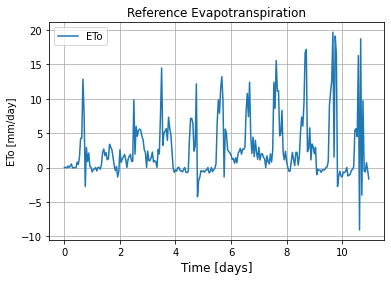

In [ ]:
# Gráficas

time1=np.arange(0,11,1/23.99)
#t=time[0:264]
plt.plot(time1,ETo,label='ETo')
plt.legend()
plt.title('Reference Evapotranspiration')
plt.xlabel('Time [days]',fontsize=12)
plt.ylabel('ETo [mm/day]')
#plt.tick_params(fontsize=18)
plt.grid()
#plt.xlim(0,3)
#plt.ylim(0,1e58)
#plt.show()
#print(max(ETohr))
#rint(ETohr)1

## Open Loop Simulation

In [ ]:
# Parameters
c1 = 1           # percolacion/humedad (1/dia)
c2 = 0.5         # relacion de humedad entre zonas vecinas (1/dia)
c3 = 1.2         # perdida de humedad/Evapotranspiracion (mm/dia)
c4 = 1           # infiltracion del suelo (mm/dia)
tm = 60/(60*24)  # tiempo de muestreo (10 minutos) en unidades de dia
# Conversion (mm/m) to % = dividir entre 10 

In [ ]:
# state space with 2 states
A=np.matrix([[1-tm*(c1+c2),c2*tm],[tm*c2,1-tm*(c1+c2)]])  
B=tm*2.4*np.diag([1,1])
# Matriz de disturbios [Eto Rtot]'
E=(tm/10)*np.matrix([[-c3,c4],[-c3,c4]])
#print(B)
#print(E)

In [ ]:
# Initial conditions to 2 states
x=np.matrix([[250],[320]])
u=np.matrix([[140],[0]])
X=x
time=np.arange(0,11,tm)
fin=len(time)
print(fin)

264


In [ ]:
# Simulation
#Rtot=zeros(1,480);
#del dis
Rtot=np.zeros(264)
Eto = ETo

dis=np.matrix(np.array([[Eto],[Rtot]])) 
#xsig=[]
for i in range(fin-1):
    #print(i)
    xsig=(A*x+B*u+E*dis[:,i]) #dist(:,i)
    #print(xsig[1])
    x=xsig
    #print(x)
    X= np.append(X,xsig,axis=1)#,[[xsig[0]], [xsig[1]]],axis=1)
    #print(X)
#X = np.matrix([X]) 
#end
#print(dis)
#print(i)

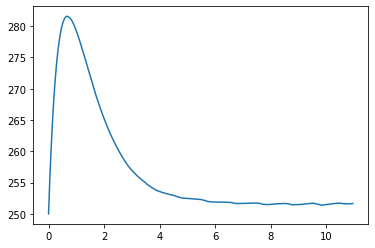

In [ ]:
plt.plot(time1, np.ravel(X[0,:]))
plt.show()

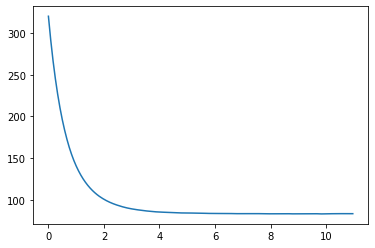

In [ ]:
plt.plot(time1, np.ravel(X[1,:]))
plt.show()

sacar los datos de humedad de suelo y los datos de evapotranspiración
simular el sistema
medida real de humedad de suelo


comparacion entre datos de humedad del modelo y los datos reales



# CONTROL MPC

### Parameters

In [ ]:
# Parameters
#c1 = 1           # percolacion/humedad (1/dia)
#c2 = 0.5         # relacion de humedad entre zonas vecinas (1/dia)
#c3 = 1.2         # perdida de humedad/Evapotranspiracion (mm/dia)
#c4 = 1           # infiltracion del suelo (mm/dia)
#tm = 60/(60*24)  # tiempo de muestreo (10 minutos) en unidades de dia
# Conversion (mm/m) to % = dividir entre 10 

c1 = 1     # percolacion/humedad (1/dia)
c2 = 1     # relacion de humedad entre zonas vecinas (1/dia)
c3 = 1.2   # perdida de humedad/Evapotranspiracion (mm/dia)
c4 = 1     # infiltracion del suelo (mm/dia)
tm = 60/(60*24)    # tiempo de muestreo (10 minutos) en unidades de dia

### state space with 2 states

In [ ]:
A=np.matrix([[1-tm*(c1+c2),c2*tm],[tm*c2,1-tm*(c1+c2)]])  
B=tm*2.4*np.diag([1,1])
# Matriz de disturbios [Eto Rtot]'
E=(tm/10)*np.matrix([[-c3,c4],[-c3,c4]])
C=np.identity(2)
#print(E)

### Initial conditions

In [ ]:

x=np.array([[380],[320]])
u=np.array([[0],[0]])
Eto = ETo
dis=np.matrix(np.array([[Eto],[Rtot]])) 
X=x

In [ ]:
# Generación de matrices para el problema QP 
N=2 # Horizonte de predicción
# Q para pesar los estados
Q=np.array([[100,0],[0,100]])
R=np.array([[91,0],[0,91]])
P = la.solve_discrete_are(A, B, Q, R)   #Riccati

### Sistem Constrains

In [ ]:
# Restricciones
vmax=np.array([1000,1000,420,420,10*tm,10*tm])  # (Hmax1, Hmax2, umax1, umax2, dumax1, dumax2)  
vmin=np.array([0,0,0,0,-10*tm,-10*tm])          # (Hmin1, Hmin2, umin1, umin2, dumin1, dumin2)
ic0 =np.array([2,1,1/2])                        #  order of vmax and vmin inputs

### QP Matrices Function

In [ ]:
def QP_matrices_curso(A,B,C,N,Q,R,P,vmin,vmax,ic0):    # Ok
  n =np.shape(B)[0]
  m =np.shape(B)[1]
  E=B
  dmax=0
  dmin=0
  e=np.shape(E)[0]   
  M=N
  
  DeltaM = []
  for i in range(len(vmax)):
      DeltaM=np.append(DeltaM,np.kron(np.ones(N),vmax[i]), axis=0)
  Deltam =[]
  for i in range(len(vmin)):
      Deltam=np.append(Deltam,np.kron(np.ones(N),vmin[i]), axis=0)
  
  # max and min of the perturbation d
  dmax = np.kron(np.ones(M),dmax)
  dmin = np.kron(np.ones(M),dmin)
  
  [H,F,Fd,Gamma,Ommega,Phi,Psi]=RHCmatrices(A,B,C,E,P,Q,R,N,N)
  CC = np.kron(np.diag(np.ones(M)),C)
  phic=[]
  L=[]
  Lc=[]
  Lu=[]
  DeltaMc=[]
  Deltamc=[]
 
  for i in range(len(ic0)):
    ic=ic0[i]    
    #######################################################  
    if ic==1:                       #input constraints
      phi = np.identity(M*m)
      L = np.zeros((M*m,n))
      rho = np.zeros((M*m,M*e))       #JZF
    #########################################################
    if ic==2:                      #state constraints (JZF)
        phi = Gamma
        L = Ommega
        if len(Phi)==0:
          DeltaM = DeltaM
          Deltam = Deltam
        else:
          rho=[]
    ###############################################
    
    if ic==0:                       #output constraints
      phi = CC*Gamma[0:M*n,0:M*m]
      L = CC*Ommega[0:M*n,:]
      if len(Phi)==0:
        DeltaM = DeltaM
        Deltam = Deltam
      else:
        rho=[]
    ###################################################
    if ic==1/2:                                       #rate constraints  ATTENTION it has to be executed at the end
        D1 = np.zeros((M,1))
        D1[0] = 1
        D1 = np.kron(D1,np.identity(m))
        D2 = np.zeros((M*m,M*m))
        D2[m:M*m,0:(M*m-m)] = np.kron(np.identity(M-1),np.identity(m))
        phi = np.identity(M*m)-D2
        L = np.zeros((M*m,n))        
        Lu = np.append((np.zeros((len(phic),m))), -D1, axis=0)        
        F = np.append(np.zeros((M*m,m)),F,axis=1)           
      #####################################################
    if len(phic)==0:
      phic=phi
    else:   
      phic = np.append(phic, phi,axis=0)    
    if len(Lc)==0:
      Lc = L
    else:
      Lc = np.append(Lc, L, axis=0)        
  Lc = np.append(Lu, Lc, axis = 1)  
  return (H,F,Fd,phic,Lc,Deltam,DeltaM)

### RHC matrices

In [ ]:
def RHCmatrices(A,B,C,E,P,q,r,N,M):      # Ok
  nx = np.shape(B)[0]
  nx = np.shape(B)[1]
  e=np.shape(E)[0]
  
  #luisRH = Eqp
  #Definition of the matrices
  Ommega = A
  for i in range(2,M+1):
    Ommega = np.append(Ommega,A**i,axis=0)
  

  gamma = np.zeros((M,M)) + np.diag(np.ones(M-1),k=-1)
  gamma = np.kron(gamma,np.identity(nx))
  Gamma = gamma*Ommega
  
  for i in range (2,M+1):
    Gamma = np.append(Gamma, (np.linalg.matrix_power(gamma,i))*Ommega,axis=1)

  Gamma = (Gamma+np.identity(M*nx))*np.kron(np.identity(M),B) 

  # Phi Matrix

  if len(E)==0:
    Phi = []

  else:
    phi = np.zeros(M) + np.diag(np.ones(M-1),k=-1)
    phi = np.kron(phi,np.identity(nx))
    Phi = phi*Ommega
    for i in range(2,M+1):
      Phi = np.append(Phi, (np.linalg.matrix_power(phi,i))*Ommega,axis=1)#Phi = np.append(Phi, (phi**i)*Ommega,axis=1)  
       
    Phi = (Phi + np.identity(M*nx))*np.kron(np.identity(M),E) # aquí es el error con matriz E
  
  # Psi Matrix
  psi = np.zeros(M) + np.diag(np.ones(M-1),k=-1)
  psi = np.kron(psi,np.identity(nx))
  Psi = psi*Ommega
  for i in range(2,M+1):
    Psi = np.append(Psi, (np.linalg.matrix_power(psi,i))*Ommega,axis=1)  
    #Psi = np.append(Psi, psi**i*Ommega,axis=1)               # Revisar el Resultado
  
  Psi = (Psi + np.identity(M*nx))*np.kron(np.identity(M),np.identity(np.size(A,1))) # Revisar el Resultado

  # Q matrix
  Q = np.kron(np.identity(M),q)

  # P Matrix in Q

  # Get Matrix Sizes 
  mq, sq = Q.shape
  mp, sp = P.shape

  # Assigning matrix portion
  Q[mq-mp:mq , sq-sp:sq] = P
  #Q(nx*N-len(P)+1:nx*N,nx*N-len(P)+1:nx*N) = P

  # R Matrix
  R = np.kron(np.identity(M),r)

  # Matrices used in the u_opt explicit solution.
  H = np.transpose(Gamma)*Q*Gamma+R                #Revisar 
  K1 = np.transpose(Gamma)*Q*Ommega
  
  if len(E)!=0:                                      # debe ir if len(E)~=1
    K2 = np.transpose(Gamma)*Q*Phi
  else:
    K2=[]    
  return (H,K1,K2,Gamma,Ommega,Phi,Psi)

In [ ]:
[H,F,Fd,phic,Lc,Deltam,DeltaM]=QP_matrices_curso(A,B,C,N,Q,R,P,vmin,vmax,ic0)

### References

In [ ]:
# References

us=np.array([[183.5],[146]])
xs=np.matrix([[410],[380]])
Us=np.kron(np.ones((N,1)),us)             # Vector de referencia constante para N instantes
um1=us                                # Valor del control al instante -1
x0=np.array([[380],[320]])            # Condiciones iniciales
Xe0=np.append(um1,x0,axis=0)          # Condiciones iniciales extendida con du
Xes=np.append([[0]],xs,axis=0)          # Vector de estados extendido por restricción du

### Quadprog

In [ ]:
def quadprog(P, q, G=None, h=None, A=None, b=None,
             initvals=None, verbose=True):
    l = -np.inf * np.ones(len(h))
    if A is not None:
        qp_A = spa.vstack([G, A]).tocsc()
        qp_l = np.hstack([l, b])
        qp_u = np.hstack([h, b])
    else:  # no equality constraint
        qp_A = G
        qp_l = l
        qp_u = h
    model = osqp.OSQP()
    model.setup(P=P, q=q,
                A=qp_A, l=qp_l, u=qp_u, verbose=verbose)
    if initvals is not None:
        model.warm_start(x=initvals)
    results = model.solve()
    return results.x, results.info.status

### Simulation

In [ ]:
ts=11
time=np.arange(0,ts,tm)
fin = len(time)
x=x0                       # Condiciones iniciales
Xresultado=np.array(x0)
Uresultado=np.array(um1)
H1 = spa.csc_matrix(H)
G1 = spa.csc_matrix(np.append(phic,-phic,axis=0))
q0 = np.ones(4)


for k in range(0,fin-1):
  Xe0=np.append(um1,x,axis=0)                   # estados actuales y control pasado
  Xes=np.append(us,xs,axis=0)
  f=F*(Xe0-Xes)-H*Us
  Uopt, xx=quadprog(H1,f,G1,np.append(DeltaM-np.ravel(Lc*Xe0), -Deltam+np.ravel(Lc*Xe0),axis=0), verbose=False)
  u=np.transpose(np.matrix(Uopt[0:2]))          #simula el controlador     
  xsig=A*x+B*u +E*dis[:,k]                      #simula proceso real
  x=xsig
  um1=u;                                        #control pasado
  Xresultado=np.append(Xresultado, x, axis = 1) #registra resultados
  Uresultado=np.append(Uresultado, u, axis = 1)
  


### Figures

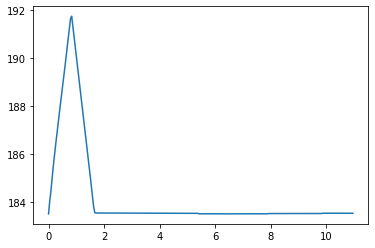

In [ ]:
plt.plot(time, np.ravel(Uresultado[0,:]))
plt.show()

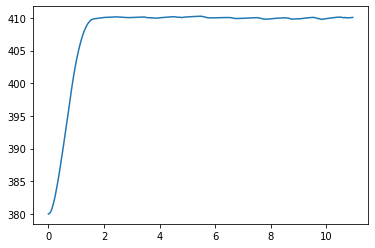

In [ ]:
plt.plot(time, np.ravel(Xresultado[0,:]))
plt.show()

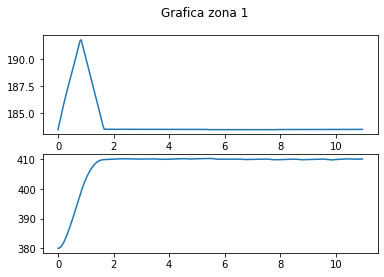

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Grafica zona 1')
axs[0].plot(time, np.ravel(Uresultado[0,:]))
axs[1].plot(time, np.ravel(Xresultado[0,:]))
plt.show()